**MASK WEAR DETECTION WITH LOGISTIC REGRESSION :**

To begin, I import the libraries I need and I redefine the DataSet class to correspond with our aim :

In [1]:
from torch.utils.data import DataLoader
import os
import cv2
import random

class DataSet :

    def __init__(self,root,k,label):
        """Initialize dataset """
        self.ROOT = root # Path
        self.k = k # Number of images we want
        self.images = read_images(root,k) # take k images from a folder with "root" path
        self.label = torch.from_numpy(np.array(label)) # To assign label to images

    def __len__(self):
        """Return number of elements in our dataset"""
        return len(self.images)

    def __getitem__(self, idx):
        """ Return the item requested by `idx`
            The PyTorch DataLoader class will use this method to make an iterable for
            the training or validation loop.
        """
        img = self.images[idx]
        label = self.label[idx]
        return img, label

I define the read_images function and I build the 2 datasets of mask and unmask people (which they will be redivided in the next to constitute the 3 datasets - Training, testing and validation - to create and improve the model) :

In [2]:
import torch
import numpy as np

def read_images(root,k) :
        '''Load k images from the "root" folder '''
        images, nb_images = [], 0
        for filename in os.listdir(root) : 
        # os.listdir(root) returns a list containing the names of the entries in the directory giv en by "root" path 
            img = cv2.imread(os.path.join(root,filename)) # Read the "filename" img from the "root" folder
            # os.path.join to obtain the image path
            # This method concatenates various path components with exactly one directory separator (‘/’) following 
            # each non-empty part except the last path component.
            nb_images += 1 
            if img is not None: # if well-loaded img
                img = img[:,:,::-1]/255 # To shuffle the color channels form BGR to RGB and /255 to normalize 
                images.append(img)
            if nb_images >= k : # if we already have the good nb of imgs 
                break
        return torch.from_numpy(np.array(images))

ds_uwm = DataSet('Um_1000',200,[0 for k in range(200)]) # 200 images in the file
ds_wm = DataSet("Wm_1000",200,[1 for k in range(200)]) # 200 images in the file

Here I take only 400 images because I cannot take more with 8Gb of RAM ...

Indeed, let's display the size of the datasets :

In [3]:
print("Worn Mask Dataset Length : {}\n".format(len(ds_wm)))
print("Unworn Mask Dataset Length : {}".format(len(ds_uwm)))

Worn Mask Dataset Length : 200

Unworn Mask Dataset Length : 200


# Training, Validation and Testing Datasets

I create here the 3 datasets :

1. **Training set** - used to train the model i.e. compute the loss and adjust the weights of the model using gradient descent.
2. **Validation set** - used to evaluate the model while training, adjust hyperparameters (learning rate etc.) and pick the best version of the model.
3. **Testing set** - used to compare different models, or different types of modeling approaches, and report the final accuracy of the model.

In [5]:
from torch.utils.data import random_split  # To split randomly images to avoid biases in datasets
from torch.utils.data import ConcatDataset # To concatenate PyTorch datasets

train_ds_wm, temp = random_split(ds_wm, [140, 60])
val_ds_wm, test_ds_wm = random_split(temp, [20, 40])

train_ds_uwm, temp = random_split(ds_uwm, [140, 60])
val_ds_uwm, test_ds_uwm = random_split(temp, [20, 40])

train_ds = train_ds_uwm + train_ds_wm  # 70% of data (meaning 140 over 200 images)
val_ds = val_ds_uwm + val_ds_wm        # 10% of data (meaning 20 over 200 images)
test_ds = test_ds_uwm + test_ds_wm     # 20% of data (meaning 40 over 200 images)

Now let's show the length of each dataset :

In [6]:
print("Length of the training set : {}\n".format(len(train_ds)))
print("Length of the validation set = {}\n".format(len(val_ds)))
print("Length of the testing set = {}\n".format(len(test_ds)))

Length of the training set : 280

Length of the validation set = 40

Length of the testing set = 80



Then let's initialize the dataloader :

In [7]:
from torch.utils.data import DataLoader

# The most important argument of DataLoader constructor is dataset, which indicates a dataset object to load data from. 
# PyTorch supports two different types of datasets:
#        - map-style datasets,
#        - iterable-style datasets

batch_size = 40

train_loader = DataLoader(train_ds, batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size)

# We set shuffle=True for the training dataloader, so that the batches generated in each epoch are different, and this 
# randomization helps generalize & speed up the training process. 
# On the other hand, since the validation dataloader is used only for evaluating the model, there is no need to shuffle 
# the images.

# Model :

Now that I have prepared the data loaders, I can define the model.

**A logistic regression model has weights and bias matrices, and the output is obtained using simple matrix operations (pred = x @ w.t() + b).**

I can use nn.Linear to create the model instead of defining and initializing the matrices manually.

Since nn.Linear expects the each training example to be a vector, each 1024x1024x3 image tensor needs to be flattened out into a vector of size 3145728 (1024x1024x3), before being passed into the model.

The output for each image is vector of size 2, with each element of the vector signifying the probability a particular target label (i.e. 0 or 1). The predicted label for an image is simply the one with the highest probability.

In [8]:
import torch.nn as nn

input_size = 1024*1024*3 # RGB images (3 dimensions) of size 1024x1024
num_classes = 2 # Mask or Unmask

# Logistic regression model
model = nn.Linear(input_size, num_classes)

Let's define the model, by extending the `nn.Module` class from PyTorch.

In [11]:
class MWDModel(nn.Module): # MWD for Mask Wear detection
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(input_size, num_classes)
        
    def forward(self, xb): 
        return self.linear(xb.reshape(-1, 1048576*3)) # Reshape to fit the self.linear()
    
model = MWDModel()

import torch.nn.functional as F # import the softmax function

Then  I transform the outputs into probabilities with the softmax function :

Finally, I can determine the predicted label for each image by simply choosing the index of the element with the highest probability in each output row. 

This is done using `torch.max`, which returns the largest element and the index of the largest element along a particular dimension of a tensor.

# Evaluation Metric and Loss Function :

I have to evaluate how well the model is performing. 

A natural way to do this would be to find the percentage of labels that were predicted correctly i.e. the **accuracy** of the predictions. 

In [18]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels.long()).item() / len(preds))

*While the accuracy is a great way for us (humans) to evaluate the model, it can't be used as a loss function for optimizing our model using gradient descent, for the following reasons:*

1. **It's not a differentiable function.** `torch.max` and `==` are both non-continuous and non-differentiable operations, so I can't use the accuracy for computing gradients w.r.t the weights and biases.

2. **It doesn't take into account the actual probabilities predicted by the model, so it can't provide sufficient feedback for incremental improvements.** 

Due to these reasons, accuracy is a great **evaluation metric** for classification, but not a good loss function. A commonly used loss function for classification problems is the **cross entropy**, which has the following formula:

![cross-entropy](https://i.imgur.com/VDRDl1D.png)

Unlike accuracy, **cross-entropy is a continuous and differentiable function that also provides good feedback for incremental improvements in the model (a slightly higher probability for the correct label leads to a lower loss)**. This makes it a good choice for the loss function. 

Moreoever, PyTorch provides an efficient and tensor-friendly implementation of cross entropy as part of the `torch.nn.functional` package and it also performs softmax internally, so I can directly pass in the outputs of the model without converting them into probabilities.

In [20]:
loss_fn = F.cross_entropy

## Training the model

Now that since I have defined the data loaders, model, loss function and optimizer, then I am ready to train the model. The training process is identical to linear regression, with the addition of a "validation phase" to evaluate the model in each epoch. Here's what it looks like in pseudocode:

```
for epoch in range(num_epochs):
    # Training phase
    for batch in train_loader:
        # Generate predictions
        # Calculate loss
        # Compute gradients
        # Update weights
        # Reset gradients
    
    # Validation phase
    for batch in val_loader:
        # Generate predictions
        # Calculate loss
        # Calculate metrics (accuracy etc.)
    # Calculate average validation loss & metrics
    
    # Log epoch, loss & metrics for inspection
```

Let's implement the problem-specific parts within our `MWDModel` class:

In [22]:
class MWDModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(input_size, num_classes)
        
    def forward(self, xb):
        return self.linear(xb.reshape(-1, 1048576*3))
    
    def training_step(self, batch):
        images, labels = batch      
        # out = self(images.float()) to generate predictions
        return F.cross_entropy(self(images.float()), labels.long()) # Calculate loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images.float())                    # Generate predictions
        loss = F.cross_entropy(self(images.float()), labels.long())   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss, 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))
    
model = MWDModel()

Now I'll define an `evaluate` function, which will perform the validation phase, and a `fit` function which will perform the entire training process.

The `fit` function records the validation loss and metric from each epoch and returns a history of the training process.

**Configurations like batch size, learning rate etc. need to picked in advance while training machine learning models, and are called hyperparameters.**. Therefore I have to try different learning rates and see how it affects the training process.

In [23]:
def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result)
        history.append(result)
    return history

Before I train the model, let's see how the model performs on the validation set with the initial set of randomly initialized weights & biases.

In [24]:
result0 = evaluate(model, val_loader)
result0

{'val_loss': 0.7239788770675659, 'val_acc': 0.5249999761581421}

The initial accuracy is around 50%, which is what one might expect from a randomly intialized model (since it has 1 chance over 2 of getting a label right by guessing randomly).

I am now ready to train the model. Let's train for 8 epochs and look at the results :

In [25]:
history = fit(8, 0.01, model, train_loader, val_loader)

Epoch [0], val_loss: 1520.1462, val_acc: 0.5000
Epoch [1], val_loss: 818.7625, val_acc: 0.5250
Epoch [2], val_loss: 27.7110, val_acc: 0.9750
Epoch [3], val_loss: 22.6550, val_acc: 0.9750
Epoch [4], val_loss: 28.5625, val_acc: 0.9750
Epoch [5], val_loss: 15.1123, val_acc: 0.9500
Epoch [6], val_loss: 26.0857, val_acc: 0.9750
Epoch [7], val_loss: 24.3947, val_acc: 0.9750
Epoch [8], val_loss: 21.5100, val_acc: 0.9750
Epoch [9], val_loss: 26.3552, val_acc: 0.9750
Epoch [10], val_loss: 24.4831, val_acc: 0.9750
Epoch [11], val_loss: 20.7877, val_acc: 0.9750
Epoch [12], val_loss: 13.7879, val_acc: 0.9750
Epoch [13], val_loss: 17.6532, val_acc: 0.9750
Epoch [14], val_loss: 15.7813, val_acc: 0.9750


Let's loot at the behavior of the loss during the evolution of the epoch :

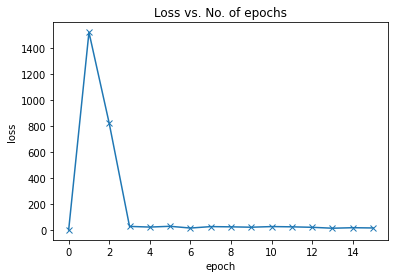

In [26]:
import matplotlib.pyplot as plt

history = [result0] + history
loss = [result['val_loss'] for result in history]
plt.plot(loss, '-x')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs. No. of epochs');

Let's loot at the behavior of the accuracy during the evolution of the epoch :

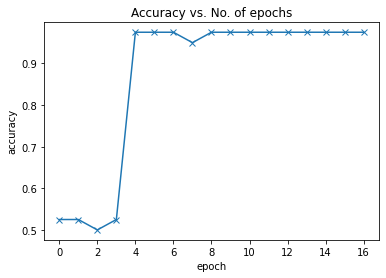

In [27]:

history = [result0] + history
accuracies = [result['val_acc'] for result in history]
plt.plot(accuracies, '-x')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. No. of epochs');

# See how it works with the testing set :

Let's look at the overall loss and accuracy of the model on the test set :

In [28]:
test_loader = DataLoader(test_ds, batch_size=80)
result = evaluate(model, test_loader)
result

{'val_loss': 4.143220901489258, 'val_acc': 0.9750000238418579}

# Testing with individual images:

I define a function that will allow to predict the label of the images:

In [29]:
def predict_image(img, model):
    xb = img.unsqueeze(0)
    yb = model(xb)
    _, preds  = torch.max(yb, dim=1)
    return preds[0].item()

Let's try now with images of masked or unmasked people taken on the internet :

In [30]:
import fnmatch # To count number of files (every kind) in a directory

new_imgs = read_images("Individual_tests_internet",len(fnmatch.filter(os.listdir("Individual_tests_internet"),'*')))

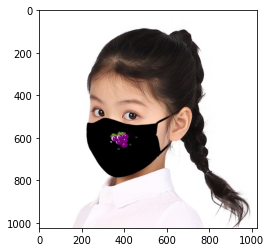

Predicted: 0


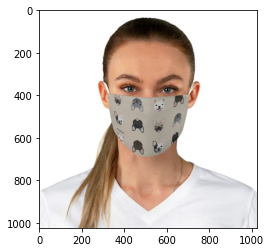

Predicted: 0


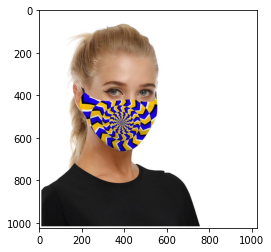

Predicted: 0


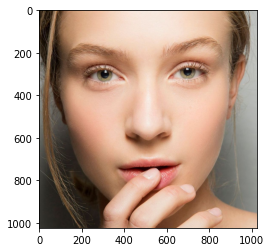

Predicted: 0


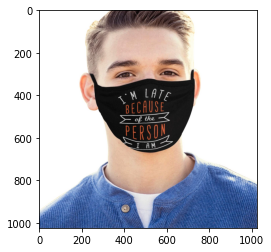

Predicted: 0


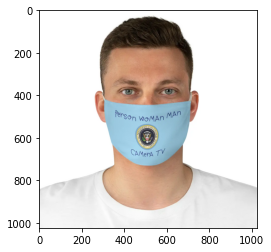

Predicted: 0


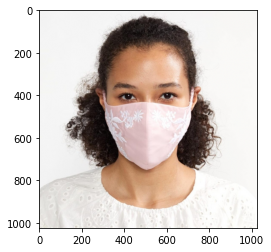

Predicted: 0


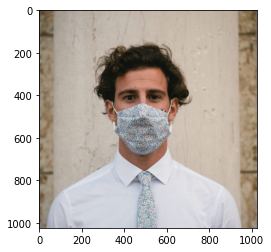

Predicted: 0


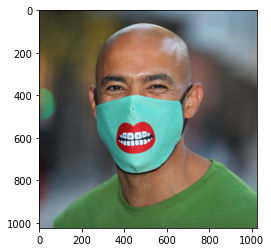

Predicted: 0


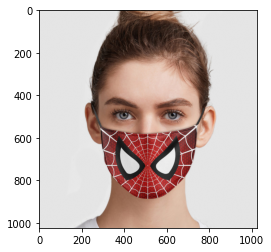

Predicted: 0


In [31]:
for i in range(len(new_imgs)) :
    plt.imshow(new_imgs[i])
    plt.show()
    print('Predicted:', predict_image(new_imgs[i].float(), model))

**I see the main bias of the model : I can detect only surgical type blue masks !**

To finish, I verify that the model works well with surgical face masks taken from the internet :

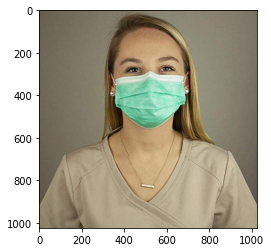

Predicted: 0


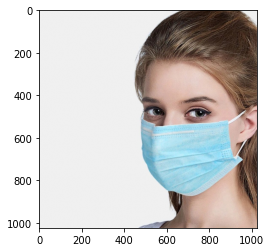

Predicted: 1


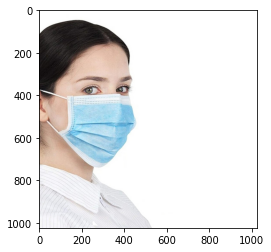

Predicted: 0


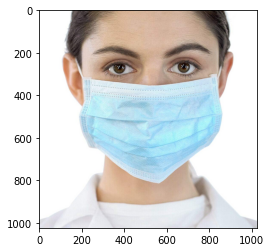

Predicted: 0


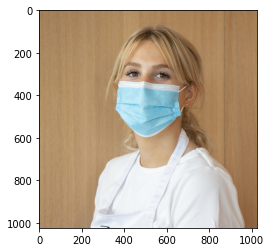

Predicted: 1


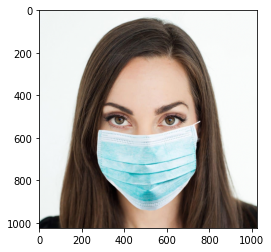

Predicted: 0


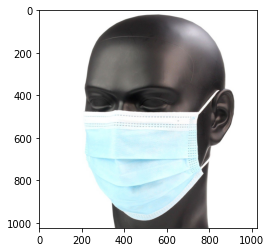

Predicted: 1


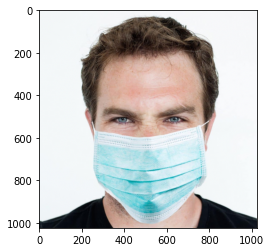

Predicted: 1


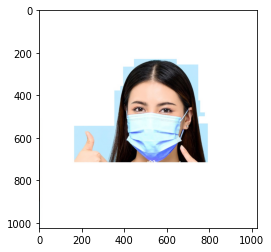

Predicted: 0


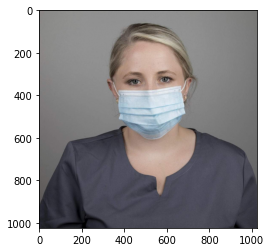

Predicted: 0


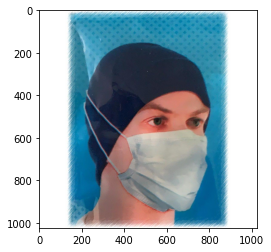

Predicted: 0


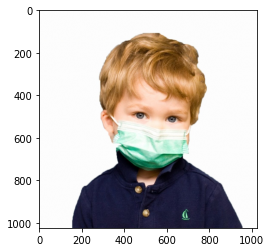

Predicted: 0


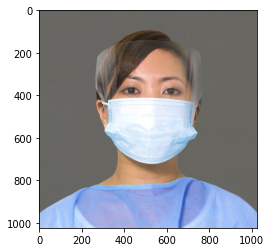

Predicted: 0


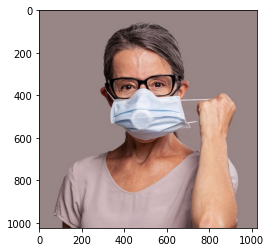

Predicted: 0


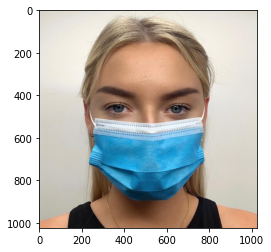

Predicted: 0


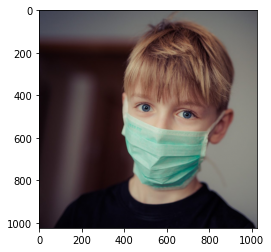

Predicted: 0


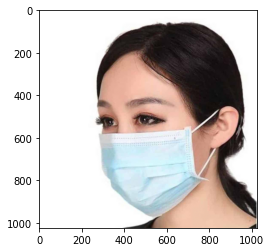

Predicted: 1


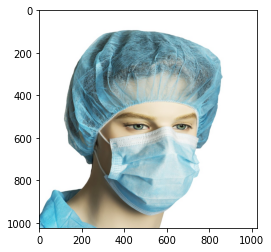

Predicted: 0


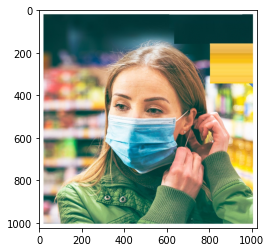

Predicted: 0


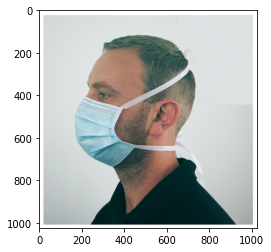

Predicted: 0


In [32]:
new_imgs = read_images("Surgical_face_masks_internet",len(fnmatch.filter(os.listdir("Surgical_face_masks_internet"),'*')))

for i in range(len(new_imgs)) :
    plt.imshow(new_imgs[i])
    plt.show()
    print('Predicted:', predict_image(new_imgs[i].float(), model))

Of the 20 surgical mask face images taken from the internet, only 5 are labeled correctly by the model, which means that only 25% are well labeled ... So the model is not really working, even for surgical masks !
I have to note that it is hard to find images 1024x1024 with persons wearing a surgical mask of good quality !